<a href="https://colab.research.google.com/github/TrueBalkar/Test_WT/blob/main/Test_WT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! pip uninstall -y Kaggle
! pip install Kaggle
from google.colab import files
files.upload()

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"a12000","key":"48ae0a63ffdcce9a7d1a9ace822e5ff4"}'}

In [9]:
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [10]:
! kaggle competitions download airbus-ship-detection

100% 28.6G/28.6G [09:41<00:00, 58.6MB/s]
100% 28.6G/28.6G [09:41<00:00, 52.8MB/s]


In [ ]:
! unzip /content/airbus-ship-detection

In [12]:
! rm airbus-ship-detection.zip

In [13]:
! pip install patchify
! pip install segmentation_models

     |████████████████████████████████| 50 kB 7.1 MB/s 


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from keras.layers import Conv2D, Input, Dropout, concatenate, UpSampling2D, \
                         MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose
from keras import Model, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


In [61]:
# Load data
masks = pd.read_csv(r"/content/train_ship_segmentations_v2.csv")
print(f"train_ship_segmentations_v2.csv:\n\n{masks.head(10)}\n\n")

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
print(f"{unique_img_ids}\n")
unique_img_ids['is_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

print(f"Count of images with/withot ships \n{unique_img_ids['is_ship'].value_counts()}\n\n")
print(f"Count of images with number (0, 1, 2 etc.) of ships \n{unique_img_ids['ships'].value_counts()}\n\n")

train_ship_segmentations_v2.csv:

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...


              ImageId  ships
0       00003e153.jpg      0
1       0001124c7.jpg      0
2       000155de5.jpg      1
3       000194a2d.jpg      5
4       0001b1832.jpg      0
...               ...    ...
192551  fffed

In [16]:
print(unique_img_ids)

              ImageId  ships  is_ship
0       00003e153.jpg      0      0.0
1       0001124c7.jpg      0      0.0
2       000155de5.jpg      1      1.0
3       000194a2d.jpg      5      1.0
4       0001b1832.jpg      0      0.0
...               ...    ...      ...
192551  fffedbb6b.jpg      0      0.0
192552  ffff2aa57.jpg      0      0.0
192553  ffff6e525.jpg      0      0.0
192554  ffffc50b4.jpg      0      0.0
192555  ffffe97f3.jpg      0      0.0

[192556 rows x 3 columns]


In [17]:
# Function to encode mask
def rle_decode(mask_rle, IMG_SIZE = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_SIZE[0]*IMG_SIZE[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(IMG_SIZE).T

In [18]:
# Here you can choose how much ships do you want to see on an image - variable 'num_ships'
num_ships = 1
print(f"ImageId's with {num_ships} ships on it \n{unique_img_ids.loc[unique_img_ids.ships == num_ships, 'ImageId'].head(5)}")

ImageId's with 1 ships on it 
2     000155de5.jpg
9     00031f145.jpg
12    00053c6ba.jpg
16    0005d6d95.jpg
17    0006c52e8.jpg
Name: ImageId, dtype: object


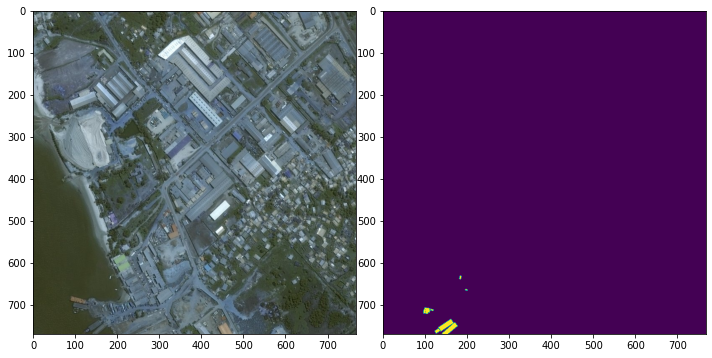

In [62]:
def display(ImageId):

    img = cv2.imread('/content/train_v2/' + ImageId)
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask, (768, 768))

    fig, axarr = plt.subplots(1, 2, figsize=(10, 20))
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    plt.tight_layout(h_pad=0.1, w_pad=0.1) # to adjust automatically axis to subplot area
    plt.show()

display('00021ddc3.jpg')

In [ ]:
# ! rm -rf /content/data/images/
# ! rm -rf /content/data/masks/
# ! mkdir /content/data/masks/
# ! mkdir /content/data/images/

In [20]:
! mkdir /content/data/
! mkdir /content/data/masks/
! mkdir /content/data/images/

In [21]:
ids_of_images = unique_img_ids.loc[unique_img_ids.ships > 13, 'ImageId'].tolist()

for ImageId in ids_of_images:
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    all_masks = np.zeros((768, 768))

    if type(img_masks[0]) != float:
        buffer = ""
        for i in img_masks:
            buffer = buffer + " " + i
        img_masks = buffer
        all_masks += rle_decode(img_masks, (768, 768))

    print("Writing: " + ImageId)
    cv2.imwrite("/content/data/masks/" + ImageId, all_masks)
    shutil.copy("/content/train_v2/" + ImageId, "/content/data/images")

Writing: 01914baf2.jpg
Writing: 02776139a.jpg
Writing: 02a09371f.jpg
Writing: 0368beab8.jpg
Writing: 03eadd139.jpg
Writing: 0445b541d.jpg
Writing: 04a2c262a.jpg
Writing: 076dd5527.jpg
Writing: 0a1a7f395.jpg
Writing: 0ba5e5a8a.jpg
Writing: 0ba729545.jpg
Writing: 0bbfa43b6.jpg
Writing: 0debfe752.jpg
Writing: 112a2d0ec.jpg
Writing: 11f3bae66.jpg
Writing: 15edd5fb8.jpg
Writing: 16ccec57a.jpg
Writing: 195b95a94.jpg
Writing: 1c9115b08.jpg
Writing: 2053a78bd.jpg
Writing: 22086d8ba.jpg
Writing: 23d9ae03d.jpg
Writing: 2531669aa.jpg
Writing: 2659080c5.jpg
Writing: 2aa9901a8.jpg
Writing: 2d5845414.jpg
Writing: 2e24f6b33.jpg
Writing: 327227baa.jpg
Writing: 375d3207f.jpg
Writing: 375def1e1.jpg
Writing: 383a66e13.jpg
Writing: 3b5086f4e.jpg
Writing: 3f33be256.jpg
Writing: 3feaa0996.jpg
Writing: 405b98f45.jpg
Writing: 41bdd5164.jpg
Writing: 46507a0d0.jpg
Writing: 4a3f658fc.jpg
Writing: 4a4a6ccd2.jpg
Writing: 4de149bd9.jpg
Writing: 4ea5a8a2f.jpg
Writing: 4fde25a38.jpg
Writing: 5084780e2.jpg
Writing: 51

In [ ]:
# ! rm -rf /content/labels/

In [ ]:
# ! ls /content/data/train

In [ ]:
# ! rm -rf /content/data_2

In [22]:
scaler = MinMaxScaler()

root_directory = '/content/data/'

patch_size = 256

In [23]:
#Read images from repsective 'images' subdirectory
#And then divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    # print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = 768
            SIZE_Y = 768
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            # image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
       
            # Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                        
                    single_patch_img = patches_img[i,j,:,:]
                        
                    # Use minmaxscaler instead of just dividing by 255. 
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                    # single_patch_img = (single_patch_img.astype('float32')) / 255. 
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    image_dataset.append(single_patch_img)

Now patchifying image: /content/data/images/e6081197c.jpg
Now patchifying image: /content/data/images/626beb313.jpg
Now patchifying image: /content/data/images/f7e6819bb.jpg
Now patchifying image: /content/data/images/0ba729545.jpg
Now patchifying image: /content/data/images/3b5086f4e.jpg
Now patchifying image: /content/data/images/ff7ac7f3c.jpg
Now patchifying image: /content/data/images/195b95a94.jpg
Now patchifying image: /content/data/images/6c4e3bea5.jpg
Now patchifying image: /content/data/images/c02a1ee0a.jpg
Now patchifying image: /content/data/images/5084780e2.jpg
Now patchifying image: /content/data/images/375d3207f.jpg
Now patchifying image: /content/data/images/c446d13fe.jpg
Now patchifying image: /content/data/images/41bdd5164.jpg
Now patchifying image: /content/data/images/fa613751e.jpg
Now patchifying image: /content/data/images/f05bc5755.jpg
Now patchifying image: /content/data/images/73361816c.jpg
Now patchifying image: /content/data/images/e1352a6d8.jpg
Now patchifyin

In [24]:
# Now do the same as above for masks
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
               
            mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            SIZE_X = 768
            SIZE_Y = 768
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            # mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
       
            # Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                        
                    single_patch_mask = patches_mask[i,j,:,:]
                    # single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    mask_dataset.append(single_patch_mask) 

Now patchifying mask: /content/data/masks/e6081197c.jpg
Now patchifying mask: /content/data/masks/626beb313.jpg
Now patchifying mask: /content/data/masks/f7e6819bb.jpg
Now patchifying mask: /content/data/masks/0ba729545.jpg
Now patchifying mask: /content/data/masks/3b5086f4e.jpg
Now patchifying mask: /content/data/masks/ff7ac7f3c.jpg
Now patchifying mask: /content/data/masks/195b95a94.jpg
Now patchifying mask: /content/data/masks/6c4e3bea5.jpg
Now patchifying mask: /content/data/masks/c02a1ee0a.jpg
Now patchifying mask: /content/data/masks/5084780e2.jpg
Now patchifying mask: /content/data/masks/375d3207f.jpg
Now patchifying mask: /content/data/masks/c446d13fe.jpg
Now patchifying mask: /content/data/masks/41bdd5164.jpg
Now patchifying mask: /content/data/masks/fa613751e.jpg
Now patchifying mask: /content/data/masks/f05bc5755.jpg
Now patchifying mask: /content/data/masks/73361816c.jpg
Now patchifying mask: /content/data/masks/e1352a6d8.jpg
Now patchifying mask: /content/data/masks/741503

In [25]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [26]:
image_dataset.shape

(1278, 256, 256, 3)

In [27]:
mask_dataset.shape

(1278, 256, 256, 3)

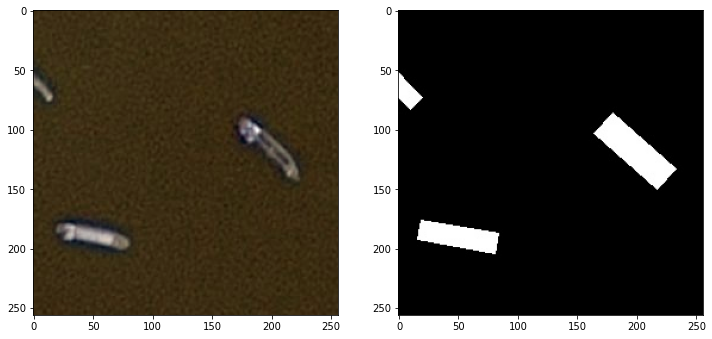

In [28]:
# Check results, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [29]:
Ship = np.array((255, 255, 255))

NotShip = np.array((0, 0, 0))

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our label masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg[np.all(label == Ship, axis=-1)] = 0
    label_seg[np.all(label== NotShip, axis=-1)] = 1
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


In [30]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [31]:
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [32]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [33]:
# Parameters for model

weights = [0.5, 0.5]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jacard_coef]

In [34]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
# model.compile(optimizer='adam', loss=dice_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [52]:
history1 = model.fit(X_train, y_train, 
                     batch_size = 32, 
                     verbose=1, 
                     epochs=20, 
                     validation_data=(X_test, y_test), 
                     shuffle=True)
model.save("/content/drive/MyDrive/model_weights/model_4.h5")

Epoch 1/20
32/32 [==============================] - 738s 23s/step - loss: 0.5672 - accuracy: 0.9946 - jacard_coef: 0.9890 - val_loss: 0.5780 - val_accuracy: 0.9931 - val_jacard_coef: 0.9862
Epoch 2/20
32/32 [==============================] - 739s 23s/step - loss: 0.5641 - accuracy: 0.9947 - jacard_coef: 0.9893 - val_loss: 0.5759 - val_accuracy: 0.9934 - val_jacard_coef: 0.9867
Epoch 3/20
32/32 [==============================] - 738s 23s/step - loss: 0.5668 - accuracy: 0.9946 - jacard_coef: 0.9891 - val_loss: 0.5764 - val_accuracy: 0.9932 - val_jacard_coef: 0.9864
Epoch 4/20
32/32 [==============================] - 737s 23s/step - loss: 0.5686 - accuracy: 0.9947 - jacard_coef: 0.9892 - val_loss: 0.5715 - val_accuracy: 0.9933 - val_jacard_coef: 0.9866
Epoch 5/20
32/32 [==============================] - 738s 23s/step - loss: 0.5659 - accuracy: 0.9947 - jacard_coef: 0.9893 - val_loss: 0.5734 - val_accuracy: 0.9931 - val_jacard_coef: 0.9861
Epoch 6/20
32/32 [==============================] 

In [36]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/model_weights/model_4.h5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

In [37]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [38]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
# n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7968147


In [44]:
testing_image = "/content/data/images/c02a1ee0a.jpg"
testing_image_patches = []

#Read images from repsective 'images' subdirectory
#And then divide all images into patches of 256x256x3. 

  
image = cv2.imread(testing_image, 1)  #Read each image as BGR
SIZE_X = 768
SIZE_Y = 768
image = Image.fromarray(image)
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
# image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
image = np.array(image)             

# Extract patches from each image
print("Now patchifying image:", path+"/"+image_name)
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
                        
        single_patch_img = patches_img[i,j,:,:]
        # Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
        # single_patch_img = (single_patch_img.astype('float32')) / 255. 
        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
        testing_image_patches.append(single_patch_img)   

Now patchifying image: /content/data/masks/7a24f72be.jpg


In [45]:
testing_image_patches = np.array(testing_image_patches)

In [46]:
testing_image_patches.shape

(9, 256, 256, 3)

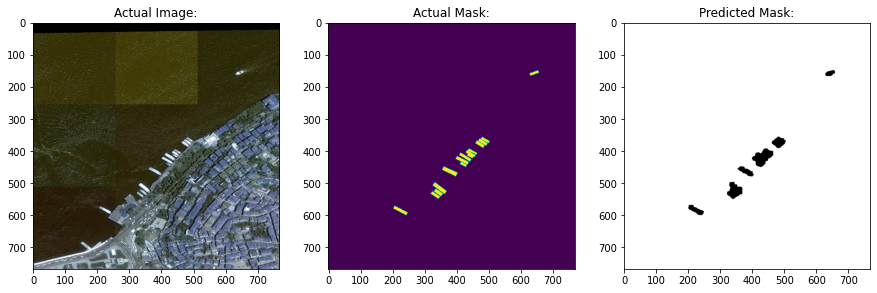

In [83]:
image_show = np.zeros((2, 768, 768, 3))
for i in range(3): 
    for j in range(3):
        for n in range(256):
            for m in range(256):
                for l in range(3):
                    image_show[1][i*256 + n][j*256 + m][l] = buffer[3*i+j][n][m]
                    image_show[0][i*256 + n][j*256 + m][l] = testing_image_patches[3*i+j][n][m][l]


img = cv2.imread(testing_image)
img_masks = masks.loc[masks['ImageId'] == testing_image[-13:], 'EncodedPixels'].tolist()

all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask, (768, 768))


plt.figure(figsize=(15, 9))
plt.subplot(131)
plt.title("Actual Image:")
plt.imshow(image_show[0])
plt.subplot(132)
plt.title("Actual Mask:")
plt.imshow(all_masks)
plt.subplot(133)
plt.title("Predicted Mask:")
plt.imshow(image_show[1])
plt.show()